In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import face_recognition
from sklearn.svm import SVC
from tqdm import tqdm
from scipy import stats

Load the data:

In [2]:
with open('../data/good_image_ids_list.pkl', 'rb') as f:
    good_images = pickle.load(f)
with open('../data/face_encodings.pkl', 'rb') as f:
    encodings = pd.DataFrame(pickle.load(f))
identities = pd.read_table('../annotations/identity_CelebA.txt', delim_whitespace=True)

Prepare the data:

In [3]:
identities = identities.loc[identities.image_id.isin(good_images)]
identity_counts = identities.groupby('identity').count()
only_2_photo_people = identity_counts.loc[identity_counts.image_id <= 2].index.tolist()
identities['person'] = identities.identity.apply(lambda x: 'unknown' if x in only_2_photo_people else str(x))
df = encodings.merge(identities, on='image_id')

Different ids with exactly same embedding:

In [4]:
df['vec_str'] = df.encoding.astype('str')
for vec, group in df.groupby('vec_str'):
    if group.shape[0] > 1:
        print(group[['image_id', 'identity']])
        print('----------------')

         image_id  identity
675    001977.jpg      1175
43301  131548.jpg      1175
----------------
         image_id  identity
18513  056077.jpg      3915
48618  148021.jpg      4610
----------------
         image_id  identity
34605  105237.jpg      6288
60105  183447.jpg      8621
----------------
         image_id  identity
40975  124527.jpg      5001
64687  195527.jpg      8611
----------------
         image_id  identity
63863  193342.jpg      5061
65442  197573.jpg      5061
----------------
         image_id  identity
9065   027613.jpg      3329
59199  180719.jpg      3330
----------------
         image_id  identity
14376  043513.jpg      9024
19139  057990.jpg      9026
----------------
         image_id  identity
47698  145229.jpg      7449
52147  158704.jpg      7449
----------------
         image_id  identity
46403  141137.jpg      5126
59113  180456.jpg      2884
----------------
         image_id  identity
17060  051617.jpg      6235
34631  105305.jpg      6236
-------

Pictures with the same id and the same embedding:

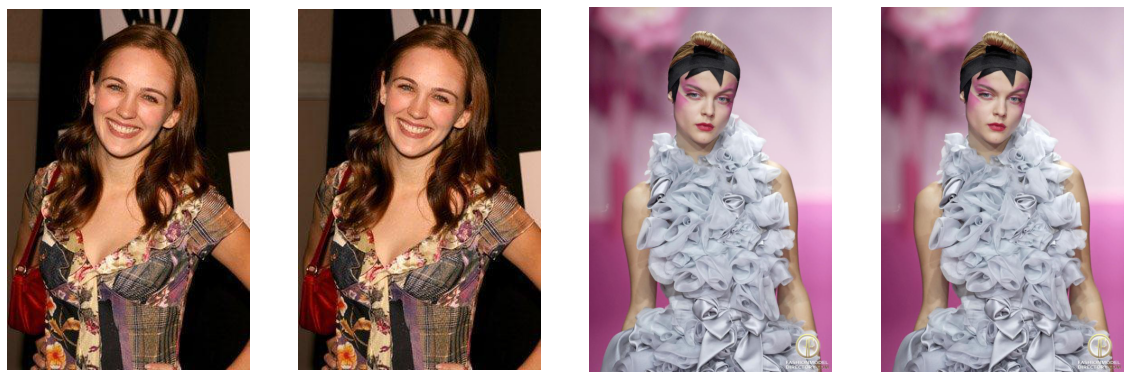

In [5]:
paths = ["../images/107222.jpg", "../images/157734.jpg",  "../images/186574.jpg",  "../images/197961.jpg"]
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    ax.imshow(image)
    ax.axis('off')

Pictures with the same embedding but different ids:

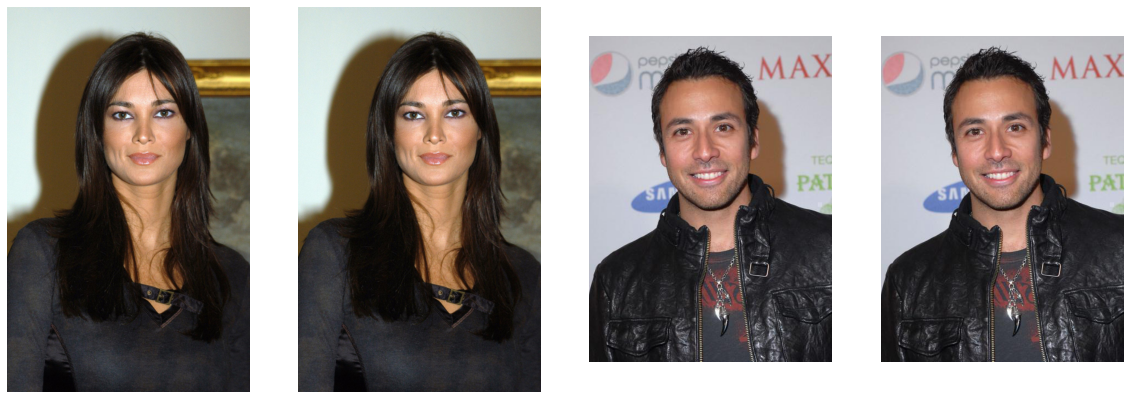

In [6]:
paths = ["../images/051617.jpg", "../images/105305.jpg",  "../images/029995.jpg",  "../images/197809.jpg"]
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    ax.imshow(image)
    ax.axis('off')

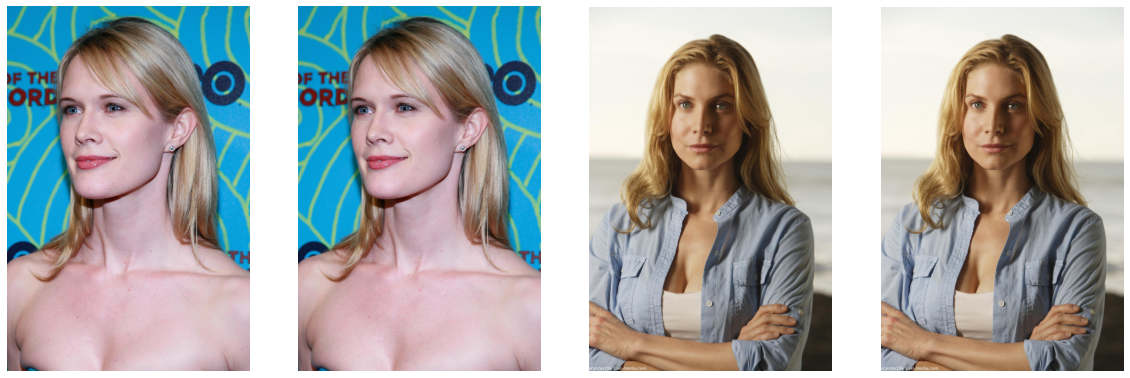

In [7]:
paths = ["../images/043513.jpg", "../images/057990.jpg",  "../images/141137.jpg",  "../images/180456.jpg"]
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    ax.imshow(image)
    ax.axis('off')

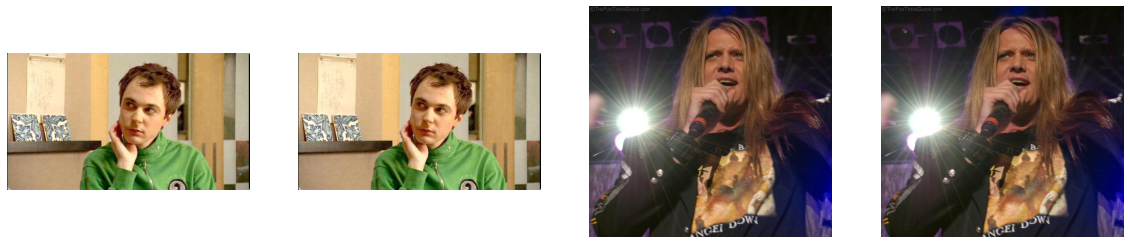

In [8]:
paths = ["../images/056077.jpg", "../images/148021.jpg",  "../images/105237.jpg",  "../images/183447.jpg"]
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    ax.imshow(image)
    ax.axis('off')

Let's trust the FaceNet and fix that:

In [9]:
changes = {}
for vec, group in df.groupby('vec_str'):
    if group.shape[0] > 1:
        if group.iloc[1]['person'] != group.iloc[0]['person']:
            changes[group.iloc[1]['image_id']] = group.iloc[1]['person'], group.iloc[0]['person']

In [10]:
for image_id, (old_person, new_person) in changes.items():
    df.loc[df.person == old_person, 'person'] = new_person

Save the dataframe:

In [11]:
with open('../data/encodings_dataframe.pkl', 'wb') as f:
    pickle.dump(df, f)

Convert needed values to numpy arrays:

In [11]:
y = df.person.to_numpy()
x = np.vstack(df.encoding.values)

Do the train/test data split:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

Check the distributions:

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['10000' 24]
 ['10003' 22]
 ['10006' 23]
 ...
 ['9986' 23]
 ['9987' 23]
 ['unknown' 532]]


In [14]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['10000' 6]
 ['10003' 5]
 ['10006' 5]
 ...
 ['9986' 6]
 ['9987' 6]
 ['unknown' 133]]


## Models

### Distance based prediction

In [15]:
list_of_train_encodings = [row for row in X_train]

In [16]:
distance_predictions, the_distances = [], []
for i, row in enumerate(tqdm(X_test)):
    distances = face_recognition.face_distance(list_of_train_encodings, row)
    closest = np.argmin(distances)
    distance = distances[closest]
    prediction = y_train[closest]
    distance_predictions.append(prediction)
    the_distances.append(distance)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13583/13583 [16:30<00:00, 13.71it/s]


In [21]:
distance_predictions = np.array(distance_predictions)

In [22]:
print(f"Accuracy (recognition rate): {accuracy_score(y_test, distance_predictions)}")
print(f"Macro F1-Score: {f1_score(y_test, distance_predictions, average='macro')}")
print(f"Unknown people classified as known: {np.logical_and(y_test == 'unknown', distance_predictions != 'unknown').sum()}")
print(f"False acceptance rate: {np.logical_and(y_test == 'unknown', distance_predictions != 'unknown').sum() / y_test.size}")
print(f"Known people classified as unknown: {np.logical_and(y_test != 'unknown', distance_predictions == 'unknown').sum()}")
print(f"False reject rate: {np.logical_and(y_test != 'unknown', distance_predictions== 'unknown').sum() / y_test.size}")
print(f"Unknown people classified as unknown: {np.logical_and(y_test == 'unknown', distance_predictions == 'unknown').sum()}")

Accuracy (recognition rate): 0.9464035927262019
Macro F1-Score: 0.9456461361471994
Unknown people classified as known: 58
False acceptance rate: 0.004270043436648752
Known people classified as unknown: 7
False reject rate: 0.0005153500699403667
Unknown people classified as unknown: 75


Closest distances distribution:

In [23]:
compare_df = pd.DataFrame({'true': y_test, 'predicted': distance_predictions, 
                           'correct': (distance_predictions==y_test), 'distance': the_distances})
compare_df.sort_values(by='distance')

,true,predicted,correct,distance
6544,5222,5222,True,0.000000
3660,5311,5311,True,0.000000
11404,6283,6283,True,0.000000
981,9807,9807,True,0.000000
5253,9057,9057,True,0.000000
...,...,...,...,...
713,4722,3587,False,0.557695
7153,unknown,2073,False,0.559093
9425,unknown,4887,False,0.562008
3091,6418,3010,False,0.567133


<AxesSubplot:xlabel='correct', ylabel='distance'>

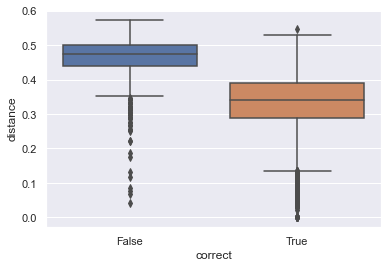

In [24]:
sns.boxplot(x="correct", y="distance", data=compare_df)

### Frequency based prediction

In [25]:
freq_predictions = []
for row in tqdm(X_test):
    comparisions = face_recognition.compare_faces(list_of_train_encodings, row)
    agreed = y_train[comparisions]
    prediction = stats.mode(agreed)
    freq_predictions.append(prediction)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13583/13583 [19:03<00:00, 11.88it/s]


In [26]:
freq_predictions = np.array(freq_predictions)[:, 0, 0]

In [27]:
print(f"Accuracy (recognition rate): {accuracy_score(y_test, freq_predictions)}")
print(f"Macro F1-Score: {f1_score(y_test, freq_predictions, average='macro')}")
print(f"Unknown people classified as known: {np.logical_and(y_test == 'unknown', freq_predictions != 'unknown').sum()}")
print(f"False acceptance rate: {np.logical_and(y_test == 'unknown', freq_predictions != 'unknown').sum() / y_test.size}")
print(f"Known people classified as unknown: {np.logical_and(y_test != 'unknown', freq_predictions == 'unknown').sum()}")
print(f"False reject rate: {np.logical_and(y_test != 'unknown', freq_predictions== 'unknown').sum() / y_test.size}")
print(f"Unknown people classified as unknown: {np.logical_and(y_test == 'unknown', freq_predictions == 'unknown').sum()}")

Accuracy (recognition rate): 0.8677758963410145
Macro F1-Score: 0.8573284929515294
Unknown people classified as known: 105
False acceptance rate: 0.0077302510491055
Known people classified as unknown: 17
False reject rate: 0.0012515644555694619
Unknown people classified as unknown: 28


### SVM

In [28]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [29]:
svm_predictions = []
for row in tqdm(X_test):
    person = clf.predict([row])
    svm_predictions.append(person)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13583/13583 [38:39<00:00,  5.86it/s]


In [30]:
svm_predictionsl = [ar[0] for ar in svm_predictions]

In [31]:
print(f"Accuracy (recognition rate): {accuracy_score(y_test, svm_predictionsl)}")
print(f"Macro F1-Score: {f1_score(y_test, svm_predictionsl, average='macro')}")
print(f"Unknown people classified as known: {np.logical_and(y_test == 'unknown', svm_predictionsl != 'unknown').sum()}")
print(f"False acceptance rate: {np.logical_and(y_test == 'unknown', svm_predictionsl != 'unknown').sum() / y_test.size}")
print(f"Known people classified as unknown: {np.logical_and(y_test != 'unknown', svm_predictionsl == 'unknown').sum()}")
print(f"False reject rate: {np.logical_and(y_test != 'unknown', svm_predictionsl== 'unknown').sum() / y_test.size}")
print(f"Unknown people classified as unknown: {np.logical_and(y_test == 'unknown', svm_predictionsl == 'unknown').sum()}")

Accuracy (recognition rate): 0.9076787160421115
Macro F1-Score: 0.9204278621606377
Unknown people classified as known: 133
False acceptance rate: 0.009791651328866967
Known people classified as unknown: 0
False reject rate: 0.0
Unknown people classified as unknown: 0


### SVM bigger C

In [32]:
clf2 = SVC(C=5.0)
clf2.fit(X_train, y_train)

SVC(C=5.0)

In [33]:
svm_predictions2 = []
for row in tqdm(X_test):
    person = clf2.predict([row])
    svm_predictions2.append(person)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13583/13583 [38:00<00:00,  5.96it/s]


In [35]:
svm_predictionsl2 = [ar[0] for ar in svm_predictions2]

In [36]:
print(f"Accuracy (recognition rate): {accuracy_score(y_test, svm_predictionsl2)}")
print(f"Macro F1-Score: {f1_score(y_test, svm_predictionsl2, average='macro')}")
print(f"Unknown people classified as known: {np.logical_and(y_test == 'unknown', svm_predictionsl2 != 'unknown').sum()}")
print(f"False acceptance rate: {np.logical_and(y_test == 'unknown', svm_predictionsl2 != 'unknown').sum() / y_test.size}")
print(f"Known people classified as unknown: {np.logical_and(y_test != 'unknown', svm_predictionsl2 == 'unknown').sum()}")
print(f"False reject rate: {np.logical_and(y_test != 'unknown', svm_predictionsl2== 'unknown').sum() / y_test.size}")
print(f"Unknown people classified as unknown: {np.logical_and(y_test == 'unknown', svm_predictionsl2 == 'unknown').sum()}")

Accuracy (recognition rate): 0.9526614150040492
Macro F1-Score: 0.95896978493283
Unknown people classified as known: 133
False acceptance rate: 0.009791651328866967
Known people classified as unknown: 0
False reject rate: 0.0
Unknown people classified as unknown: 0
